In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import zipfile
import os
import shutil
import h3
from shapely.geometry import Polygon
import osmnx as ox
from shapely.geometry import Point

# Load Metropolitan Area

In [2]:
metropolitan_cdmx = gpd.read_file('./data/metropolis_2020/unified.geojson')

# Extracting DENUE

In [3]:
def extract_denue_data(zip_path, target_directory):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('./data/temp_extract')

    os.makedirs(target_directory, exist_ok=True)

    source_dir = './data/temp_extract/conjunto_de_datos/'
    for filename in os.listdir(source_dir):
        source_file = os.path.join(source_dir, filename)
        target_file = os.path.join(target_directory, filename)
        os.rename(source_file, target_file)

    shutil.rmtree('./data/temp_extract')

# CDMX

In [4]:
extract_denue_data('./data/denue/cdmx_shp.zip', './data/denue/cdmx/')

In [5]:
cdmx_denue = gpd.read_file('./data/denue/cdmx/denue_inegi_09_.shp')

## Hidalgo

In [6]:
extract_denue_data('./data/denue/hidalgo_shp.zip', './data/denue/hidalgo/')   

In [7]:
hidalgo_denue = gpd.read_file('./data/denue/hidalgo/denue_inegi_13_.shp')

## Edo Mex

In [8]:
extract_denue_data('./data/denue/edomex_1_shp.zip', './data/denue/edomex_1/')
extract_denue_data('./data/denue/edomex_2_shp.zip', './data/denue/edomex_2/')

In [9]:
edomex_denue_1 = gpd.read_file('./data/denue/edomex_1/denue_inegi_15_1.shp')
edomex_denue_2 = gpd.read_file('./data/denue/edomex_2/denue_inegi_15_2.shp')

In [10]:
edomex_denue = gpd.GeoDataFrame(pd.concat([edomex_denue_1, edomex_denue_2], ignore_index=True), crs=edomex_denue_1.crs)
del edomex_denue_1
del edomex_denue_2

# Metropolitan Area DENUE

In [11]:
single_denue = gpd.GeoDataFrame(pd.concat([cdmx_denue, hidalgo_denue, edomex_denue], ignore_index=True), crs=cdmx_denue.crs)

In [12]:
single_denue = single_denue[['id', 'clee', 'nom_estab', 'raz_social', 'codigo_act', 'nombre_act',
       'per_ocu', 'tipo_vial', 'nom_vial', 'tipo_v_e_1', 'nom_v_e_1',
       'tipo_v_e_2', 'nom_v_e_2', 'tipo_v_e_3', 'nom_v_e_3', 'numero_ext',
       'letra_ext', 'edificio', 'edificio_e', 'numero_int', 'letra_int',
       'tipo_asent', 'nomb_asent', 'tipoCenCom', 'nom_CenCom', 'num_local',
       'cod_postal', 'cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc',
       'localidad', 'ageb', 'manzana', 'telefono', 'correoelec', 'www',
       'tipoUniEco', 'fecha_alta', 'geometry']]

In [13]:
metropolitan_cdmx.crs

<Projected CRS: EPSG:32614>
Name: WGS 84 / UTM zone 14N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102°W and 96°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-102.0, 0.0, -96.0, 84.0)
Coordinate Operation:
- name: UTM zone 14N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
single_denue.to_crs(epsg=4326, inplace=True)
single_denue.to_crs("EPSG:32614", inplace=True)

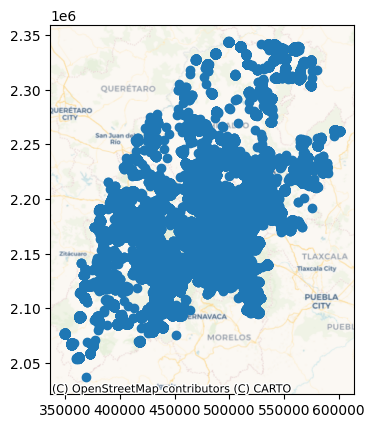

In [15]:
single_denue.plot()
ctx.add_basemap(plt.gca(), crs=metropolitan_cdmx.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

In [16]:
single_denue.shape[0]

1437052

In [17]:
single_denue_cut = single_denue.clip(metropolitan_cdmx)
del single_denue
del cdmx_denue
del hidalgo_denue
del edomex_denue

In [18]:
single_denue_cut.columns

Index(['id', 'clee', 'nom_estab', 'raz_social', 'codigo_act', 'nombre_act',
       'per_ocu', 'tipo_vial', 'nom_vial', 'tipo_v_e_1', 'nom_v_e_1',
       'tipo_v_e_2', 'nom_v_e_2', 'tipo_v_e_3', 'nom_v_e_3', 'numero_ext',
       'letra_ext', 'edificio', 'edificio_e', 'numero_int', 'letra_int',
       'tipo_asent', 'nomb_asent', 'tipoCenCom', 'nom_CenCom', 'num_local',
       'cod_postal', 'cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc',
       'localidad', 'ageb', 'manzana', 'telefono', 'correoelec', 'www',
       'tipoUniEco', 'fecha_alta', 'geometry'],
      dtype='object')

In [19]:
metropolitan_cdmx_denue = single_denue_cut[['id', 'clee', 'codigo_act', 'per_ocu', 'cve_ent', 'entidad', 'cve_mun', 'municipio', 'fecha_alta', 'geometry']]
del single_denue_cut

# Urban Economic Centers using the DENUE

In [20]:
econocic_corridors = metropolitan_cdmx_denue.copy()

economic_corridors_activity_codes_list = [ 
    # Wholesale, retail
    '43', 
    '46',
    # Professional services, management, admin
    '51', # Media
    '52', # Finance and insurance
    '53', # Real estate and rental
    '54', # Professional, scientific, and technical services
    '55', # Management of companies and enterprises
    '56',
    # Education & health services
     '61', # Educational services
     '62', # Health care and social assistance
    # Government
    '93', # Public administration
    # Industrial/logistics
    # '31', # Utilities
    # '32', # Construction
    # '33', # Manufacturing
    # '48', # Transportation and warehousing
    # '49', # Transportation and warehousing
    # Tourism / accommodation
    '72', # Accommodation and food services
    # Entertainment and recreation
    '71',
]

In [21]:
econocic_corridors.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1054566 entries, 293045 to 513296
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype   
---  ------      --------------    -----   
 0   id          1054566 non-null  int32   
 1   clee        1054566 non-null  object  
 2   codigo_act  1054566 non-null  object  
 3   per_ocu     1054566 non-null  object  
 4   cve_ent     1054566 non-null  object  
 5   entidad     1054566 non-null  object  
 6   cve_mun     1054566 non-null  object  
 7   municipio   1054566 non-null  object  
 8   fecha_alta  1054566 non-null  object  
 9   geometry    1054566 non-null  geometry
dtypes: geometry(1), int32(1), object(8)
memory usage: 84.5+ MB


In [22]:
#first two chars only
econocic_corridors["clave_actividad_economica"] = econocic_corridors["codigo_act"].str[:2]
econocic_corridors[["codigo_act", "clave_actividad_economica"]]


,codigo_act,clave_actividad_economica
293045,561432,56
45234,434211,43
101898,461110,46
58981,461110,46
219392,461110,46
...,...,...
494044,461110,46
533051,461110,46
491606,461110,46
585213,722518,72


In [23]:
econocic_corridors = econocic_corridors[econocic_corridors['clave_actividad_economica'].isin(economic_corridors_activity_codes_list)]

In [24]:
econocic_corridors.shape[0]

802556

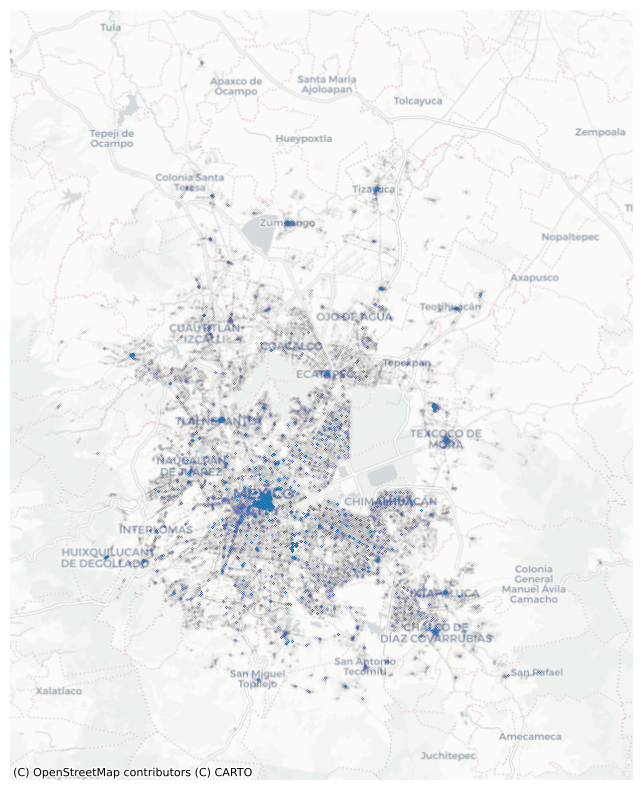

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
econocic_corridors.plot(ax=ax, markersize=0.00001, alpha=0.75)
ctx.add_basemap(ax, crs=metropolitan_cdmx.crs.to_string(), source=ctx.providers.CartoDB.Positron)

## Creating economic hexagons

In [26]:
# create h3 index for each listing of 1 km2 -> resolution 8
econocic_corridors.to_crs("EPSG:4326", inplace=True)

econocic_corridors["h3_index"] = econocic_corridors.geometry.apply(lambda x: h3.latlng_to_cell(x.y, x.x, 8))  

agg = (
    econocic_corridors
    .groupby("h3_index")
    .size()
    .reset_index(name='count')
)

In [27]:
hex_polygons = []

for h in agg["h3_index"]:
    boundary = h3.cell_to_boundary(h,)
    polygon = Polygon([(p[1], p[0]) for p in boundary])
    hex_polygons.append(polygon)

econocic_corridors_h3 = gpd.GeoDataFrame(agg, geometry=hex_polygons, crs="EPSG:4326")
econocic_corridors_h3.to_crs("EPSG:32614", inplace=True)

Text(0.5, 1.0, 'Population change 1990-2000')

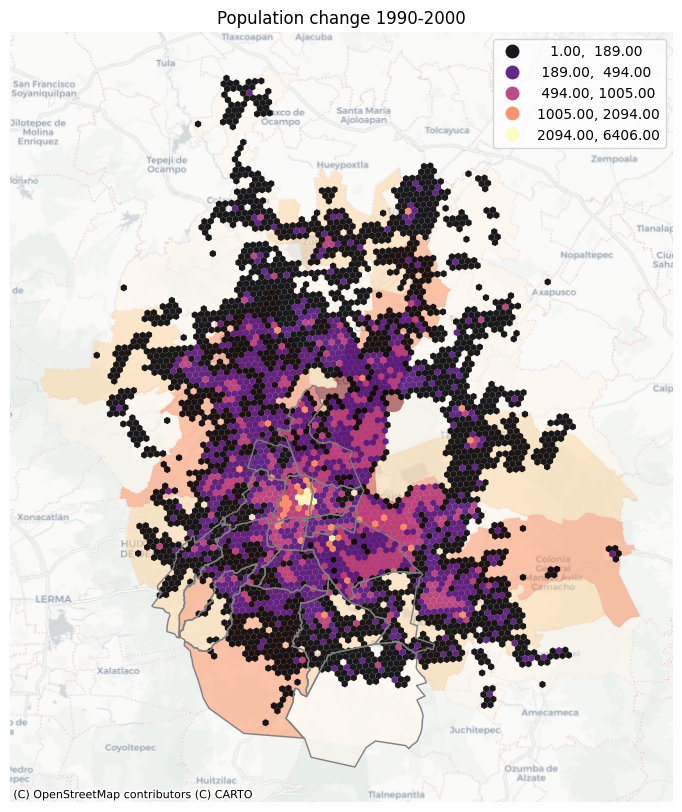

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.axis('off')

metropolitan_cdmx.plot(ax=ax, column='pop_2020', cmap="OrRd",scheme='naturalbreaks', alpha=0.5, edgecolor='none', legend=True)
econocic_corridors_h3.plot(ax=ax, column='count', cmap='magma', edgecolor='none', legend=True, scheme='naturalbreaks', alpha=0.9) 
metropolitan_cdmx[metropolitan_cdmx["cve_ent"]=="09"].plot(ax=ax, facecolor="none", edgecolor='gray')
ctx.add_basemap(ax, crs=econocic_corridors_h3.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_title('Population change 1990-2000')

# Airbnb Streak

In [29]:
airbnb_listings = pd.read_csv('./data/airbnb/listings.csv')

#airbnb_listings = gpd.GeoDataFrame(airbnb_listings, geometry=gpd.points_from_xy(airbnb_listings.longitude, airbnb_listings.latitude), crs='EPSG:4326')

In [30]:
airbnb_listings = gpd.GeoDataFrame(airbnb_listings, geometry=gpd.points_from_xy(airbnb_listings.longitude, airbnb_listings.latitude), crs='EPSG:4326')
airbnb_listings.to_crs("EPSG:32614", inplace=True)

In [31]:
airbnb_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [32]:
airbnb_listings_temporal = airbnb_listings[airbnb_listings["first_review"].notnull()]

airbnb_listings_temporal["year_first_review"] = pd.to_datetime(airbnb_listings_temporal["first_review"]).dt.year

airbnb_listings_temporal = airbnb_listings_temporal.sort_values(by="year_first_review")

/var/folders/wq/fkfjjd7j01z6bc6329g87fv40000gn/T/ipykernel_8174/3576999282.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  airbnb_listings_temporal["year_first_review"] = pd.to_datetime(airbnb_listings_temporal["first_review"]).dt.year
/Users/juandiaz/urba_data_story/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [33]:
# Cut to 2024 as 2024 is the last complete year
airbnb_listings_temporal = airbnb_listings_temporal[airbnb_listings_temporal["year_first_review"]!=2025]

<Axes: title={'center': 'Number of first reviews per year in Airbnb listings in Mexico City Central Metropolitan Area'}, xlabel='year_first_review'>

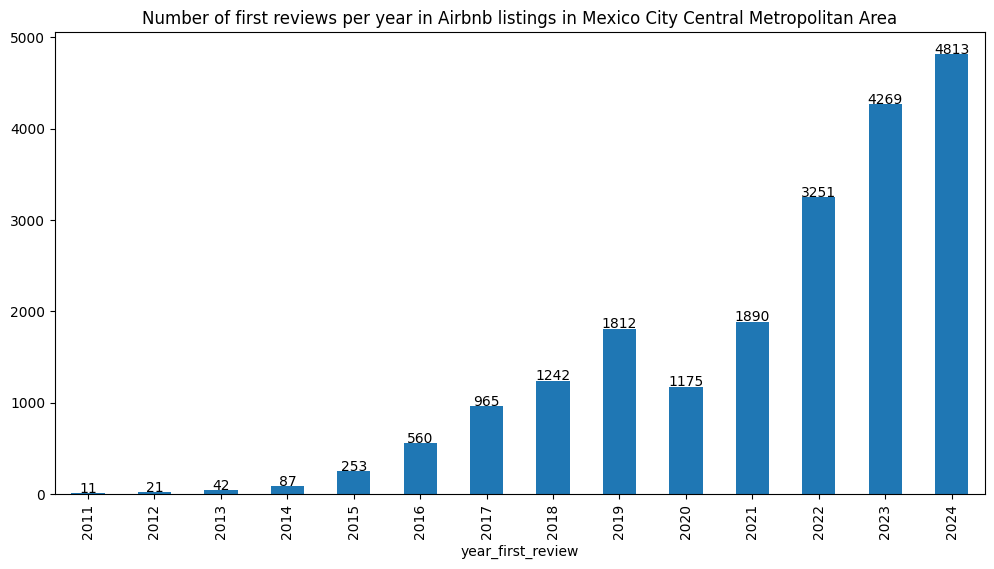

In [34]:

for i, v in enumerate(airbnb_listings_temporal["year_first_review"].value_counts().sort_index()):
    plt.text(i, v + 5, str(v), ha='center')

airbnb_listings_temporal["year_first_review"].value_counts().sort_index().plot(kind='bar', figsize=(12,6), title='Number of first reviews per year in Airbnb listings in Mexico City Central Metropolitan Area')

# Airbnb Hexagons

In [35]:
# create h3 index for each listing of 1 km2 -> resolution 8

airbnb_listings.to_crs(epsg=4326, inplace=True)

airbnb_listings["h3_index"] = airbnb_listings.apply(
    lambda row: h3.latlng_to_cell(row.geometry.y, row.geometry.x, 8),
    axis=1,
)

agg = (
    airbnb_listings
        .groupby("h3_index")
        .size()
        .reset_index(name="count")
)

In [36]:
hex_polygons = []

for h in agg["h3_index"]:
    boundary = h3.cell_to_boundary(h,)
    polygon = Polygon([(p[1], p[0]) for p in boundary])
    hex_polygons.append(polygon)

airbnb_listings_h3 = gpd.GeoDataFrame(agg, geometry=hex_polygons, crs="EPSG:4326")
airbnb_listings_h3.to_crs("EPSG:32614", inplace=True)

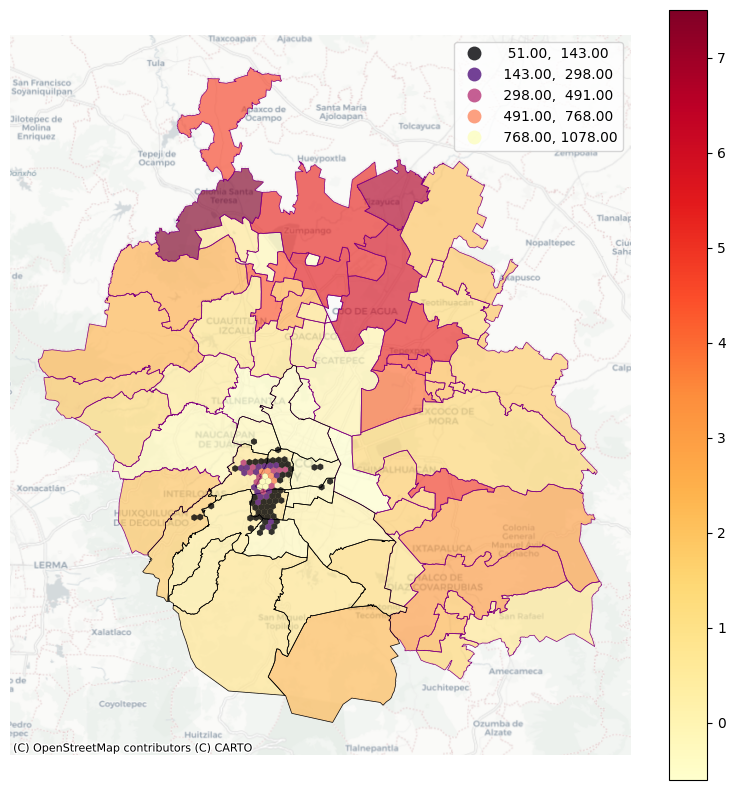

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
metropolitan_cdmx.plot(ax=ax, column='change_2000_2020', cmap="YlOrRd", edgecolor='none', alpha=0.65, legend=True)
metropolitan_cdmx[metropolitan_cdmx["cve_ent"]!="09"].plot(ax=ax, facecolor='none', edgecolor='purple', linewidth=0.5)
metropolitan_cdmx[metropolitan_cdmx["cve_ent"]=="09"].plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
airbnb_listings_h3[airbnb_listings_h3["count"] >=50].plot(column='count', cmap='magma', legend=True, figsize=(10,10), ax=ax, edgecolor='black', linewidth=0.05, scheme='naturalbreaks', alpha=0.8)
ctx.add_basemap(plt.gca(), crs=airbnb_listings_h3.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Accesibilty measured through walking distance

## Network Stablishment

In [38]:
walk_time = 20  # max walking horizon in minutes
walk_speed = 4.5  # km per hour

In [39]:
econocic_corridors_h3_copy = econocic_corridors_h3.copy()
econocic_corridors_h3_copy.to_crs(epsg=4326, inplace=True)

In [40]:
metropolitan_cdmx_copy_4326 = metropolitan_cdmx.copy()
metropolitan_cdmx_copy_4326.to_crs(epsg=4326, inplace=True)

In [41]:
econocic_corridors_h3_copy = econocic_corridors_h3_copy.overlay(metropolitan_cdmx_copy_4326[metropolitan_cdmx_copy_4326["cve_ent"]=="09"], how='intersection')

In [60]:
single_polygon = metropolitan_cdmx_copy_4326[metropolitan_cdmx_copy_4326["cve_ent"]=="09"]
single_polygon = single_polygon.unary_union
single_polygon = metropolitan_cdmx_copy_4326
single_polygon = single_polygon.unary_union

/var/folders/wq/fkfjjd7j01z6bc6329g87fv40000gn/T/ipykernel_8174/1238324880.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  single_polygon = single_polygon.unary_union
/var/folders/wq/fkfjjd7j01z6bc6329g87fv40000gn/T/ipykernel_8174/1238324880.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  single_polygon = single_polygon.unary_union


In [61]:
G_Walk = ox.graph_from_polygon(single_polygon, network_type='walk', simplify=True)

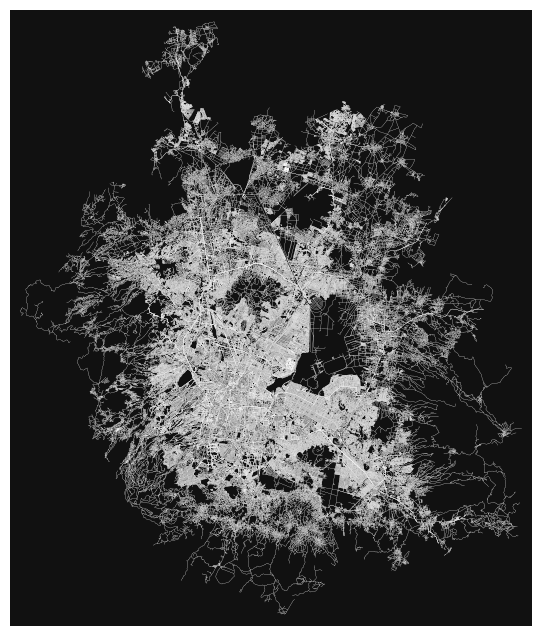

In [62]:
fig, ax = ox.plot.plot_graph(G_Walk, node_size=0, edge_color="w", edge_linewidth=0.1)

In [63]:
for _, _, data in G_Walk.edges(data=True):
    data["speed_kph"] = walk_speed
G_walk = ox.routing.add_edge_travel_times(G_Walk)

In [64]:
nodes = ox.convert.graph_to_gdfs(G_walk, edges=False)[["x", "y"]]
edges = ox.convert.graph_to_gdfs(G_walk, nodes=False).reset_index()[["u", "v", "travel_time"]]

In [66]:
tags = {
    # --- Daily needs, schools, parks, etc. ---
    "shop": [
        "supermarket", "grocery", "greengrocer",
        "convenience", "bakery"
    ],
    "amenity": [
        "kindergarten", "school", "college", "university",
        "clinic", "doctors", "hospital", "dentist", "pharmacy",
        "library", "arts_centre", "cinema", "community_centre",
        "bank", "post_office", "cafe", "restaurant"
    ],
    "leisure": ["park", "playground", "garden", "fitness_station"],

    # --- Public transport ---
    
    "public_transport": [
        "platform",          # general platform
        "stop_position",     # precise stop point
        "station",           # transit stations
        "stop_area",         # grouped stops
        "stop_area_group",   # multimodal areas
        "ticket_validator",  # optional but useful for entrances
        "entrance",          # station access points
        "waiting_room",      # bus/trolley waiting
        "shelter"            # covered waiting area
    ],

    # Rail-based transit
    "railway": [
        "station",           # main stations
        "halt",              # small stations
        "tram_stop",         # tram/light rail
        "subway_entrance",   # metro entrances
        "light_rail",        # Light rail platforms & infra
        "platform"           # platform lines
    ],

    # Bus
    "highway": [
        "bus_stop",          # standard bus stops
        "bus_station"        # regional bus terminals
    ],
    
    # Bus/trolleybus infrastructure
    "bus": ["stop", "station"],
    "trolleybus": ["stop"],

    # Metro / subway
    "subway": ["entrance"],  # some cities use subway=entrance

    # Tram
    "tram": ["stop"],

    # Aerial cable, gondola (important in cities like CDMX, Medellín)
    "aerialway": [
        "station",  # cable car station
        "gondola",
        "cable_car"
    ]
}
bbox = nodes["x"].min(), nodes["y"].min(), nodes["x"].max(), nodes["y"].max()
amenities = ox.features.features_from_bbox(bbox, tags=tags)
amenities.shape

(37550, 455)

In [48]:
#!python -c "import numpy; print(numpy.__version__)"

1.26.4


In [49]:
#!uv add "numpy<2.0" pandana

Resolved 166 packages in 11ms
Audited 163 packages in 32ms


In [51]:
import pandana

In [74]:
# construct the pandana network model
network = pandana.Network(
    node_x=nodes["x"],
    node_y=nodes["y"],
    edge_from=edges["u"],
    edge_to=edges["v"],
    edge_weights=edges[["travel_time"]],
)

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 550238
Setting CH edge vector of size 1490538
Range graph removed 1505626 edges of 2981076
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [75]:
centroids = amenities.centroid

/var/folders/wq/fkfjjd7j01z6bc6329g87fv40000gn/T/ipykernel_8174/1232309418.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = amenities.centroid


In [76]:
maxdist = walk_time * 60  # minutes -> seconds, to match travel_time units
network.set_pois(
    category="stop_area", maxdist=maxdist, maxitems=5, x_col=centroids.x, y_col=centroids.y
)

In [77]:
# calculate travel time to nearest amenity from each node in network
distances = network.nearest_pois(distance=maxdist, category="stop_area", num_pois=5, )
distances.astype(int).head()

,1,2,3,4,5
osmid,,,,,
268803401,0,146,189,357,357
268803404,154,342,408,489,532
268803406,295,333,584,645,677
268803413,115,135,252,259,264
268803497,42,117,233,241,245


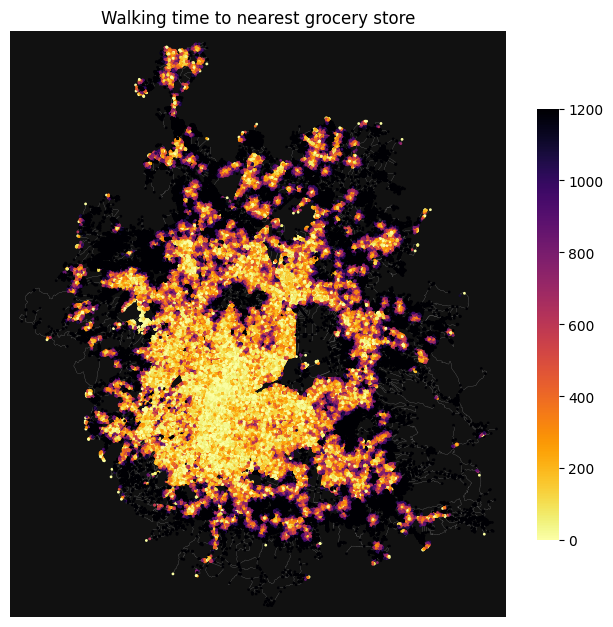

In [78]:
# plot distance to nearest amenity
fig, ax = ox.plot.plot_graph(
    G_walk, node_size=0, edge_linewidth=0.1, edge_color="gray", show=False, close=False
)

sc = ax.scatter(x=nodes["x"], y=nodes["y"], c=distances[1], s=1, cmap="inferno_r")

ax.set_title("Walking time to nearest grocery store")
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor("none")

In [131]:
node_ids = network.get_node_ids(centroids.x, centroids.y)
network.set(node_ids, name="stop_area")

# aggregate the variable to all the nodes in the network
# when counting, the decay doesn't matter (but would for summing)
access = network.aggregate(distance=maxdist, type="count", decay="linear", name="stop_area")

# let's cap it at 5, assuming no further utility from a larger choice set
access = access.clip(upper=20)
access.describe()

count    550238.000000
mean         13.803033
std           7.903778
min           0.000000
25%           6.000000
50%          20.000000
75%          20.000000
max          20.000000
dtype: float64

In [132]:
nodes = ox.convert.graph_to_gdfs(G_walk, edges=False)[["x", "y"]]
nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes.x, nodes.y), crs="EPSG:4326")
nodes.to_crs(epsg=32614, inplace=True)

In [133]:
nodes["x"] = nodes.geometry.x
nodes["y"] = nodes.geometry.y

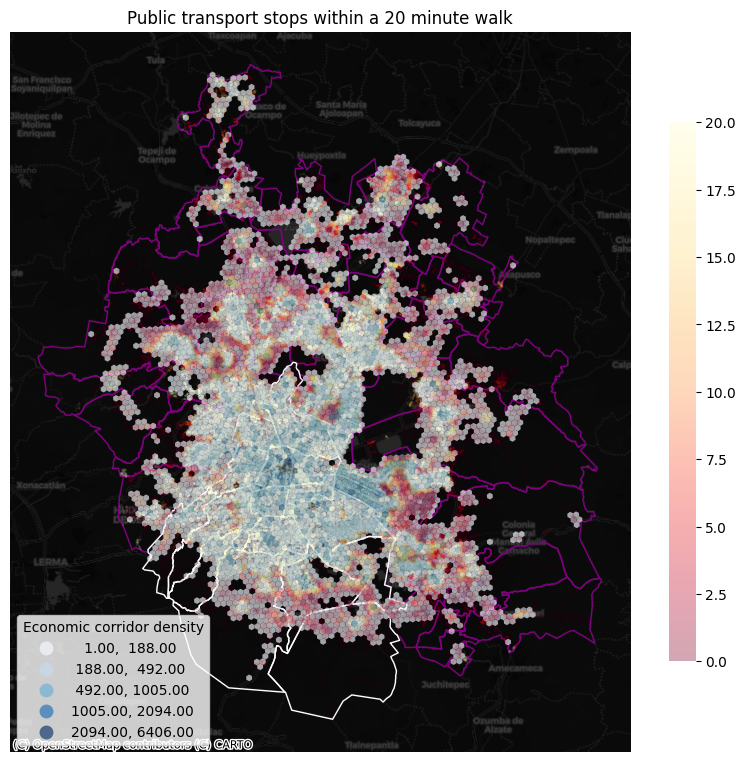

In [148]:
# plot amenity count within your walking horizon
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')

metropolitan_cdmx[metropolitan_cdmx["cve_ent"]!="09"].plot(ax=ax, facecolor="none", edgecolor='purple')

metropolitan_cdmx[metropolitan_cdmx["cve_ent"]=="09"].plot(ax=ax, facecolor="none", edgecolor='white')


sc = ax.scatter(x=nodes["x"], y=nodes["y"], c=access, s=0.0005, cmap="YlOrRd_r", alpha=1)

econocic_corridors_h3.plot(column='count', cmap='Blues', legend=True, figsize=(10,10), ax=ax, edgecolor='black', linewidth=0.05, scheme='naturalbreaks', alpha=0.65, legend_kwds={'title': "Economic corridor density"})

sc1 = ax.scatter(x=nodes["x"], y=nodes["y"], c=access, s=0.0005, cmap="YlOrRd_r", alpha=0.35)

ctx.add_basemap(ax, crs=metropolitan_cdmx.crs.to_string(), source=ctx.providers.CartoDB.DarkMatter)

ax.set_title(f"Public transport stops within a {walk_time} minute walk")
plt.colorbar(sc1, shrink=0.7).outline.set_edgecolor("none")